In [1]:
%load_ext autoreload

import os
import sys
sys.path.append('../../..')
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import config
import main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

# Choose to load data (True) or start a new scan (False)
load_data = True

In [3]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [53]:
# f for decay to photons from 1610.06933
f_CLW = np.array([
    [10000, 0.09847589669714873],
    [16058.844238352904, 0.0675647830170246],
    [25788.647827168028, 0.06125016598485203],
    [41413.58785742311, 0.06759326208217092],
    [63095.73444801891, 0.07644789494586095],
    [101324.45716052217, 0.07966189541761039],
    [162715.3675076487, 0.0728108729440447],
    [261302.07419916798, 0.05885197711865242],
    [339960.5877642238, 0.04914961059618436],
    [419620.9308722989, 0.04241347076088932],
    [545937.4126084594, 0.033999242609005144],
    [710278.3406586583, 0.027254277408769012],
    [831763.7711026674, 0.02276005779036828],
    [1026664.5618874491, 0.01869841432818515],
    [1267234.9521044958, 0.015615418750760916],
    [1648704.628438744, 0.012829071368921426],
    [2260922.7001714776, 0.016272679645948106],
    [2647629.082314918, 0.017955363610903368],
    [3268027.5894101122, 0.024922042362227576],
    [4033799.294804449, 0.03402950389398694],
    [5248074.602497712, 0.04387597104728988],
    [6477815.4564042175, 0.05429928396899368],
    [10402622.94191911, 0.06775962937391997],
    [15848931.924611043, 0.06945899905638016],
    [25451552.91215885, 0.06143830811165539],
    [40872252.38405579, 0.05708240831134203],
    [65636113.470619746, 0.052173249922175674],
    [105404012.2635548, 0.045398466107785945],
    [169266661.50378728, 0.038229585855101174],
    [286512026.9663758, 0.03064896842419112],
    [436515832.24016297, 0.025597961934800784],
    [700993975.7519821, 0.020690462964628537],
    [912010839.3559003, 0.0181502054556146],
    [1186549100.0980434, 0.016052829811419513],
    [1543730300.3304071, 0.014081954556520981],
    [2008432048.839189, 0.012660487597537271],
    [2613020741.991669, 0.011570586235969564],
    [4196209308.722972, 0.010927878088782655],
    [10266645618.874493, 0.011296491214206197],
    [16487046284.38744, 0.010845297868158476],
    [21450062968.36389, 0.010158335973518577],
    [121818791201.01048, 0.010249833900252471],
    [158489319246.1098, 0.01310778267797295],
    [254515529121.58746, 0.016627371079877034],
    [408722523840.5563, 0.01400173981062695],
    [656361134706.1947, 0.012693134635857787],
    [999999999999.9918, 0.01269551224723241]
])

In [51]:
# Load data
data_list = []
#dir_str = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/max_CMB_nmax_200_Puchwein/'
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_nmax_200_runs/'

directory = os.fsencode(dir_str)
skip = 1

for file in tqdm(sorted(os.listdir(directory))[::skip]): 
    filename = os.fsdecode(file)
    data_list.append(pickle.load(open(dir_str+filename, 'rb')))

# Make lists of masses and f_Hion[300]
mDM_list = np.zeros(40)
fHion_list = np.zeros(40)

count = 0
for i, datum in enumerate(data_list):
    if datum['DM_params']['pri'] == 'phot' and datum['DM_params']['DM_process'] == 'decay':
        mDM_list[count] = datum['DM_params']['mDM']
        fHion_list[count] = datum['data'][-1]['f']['H ion'][144]
        count+=1

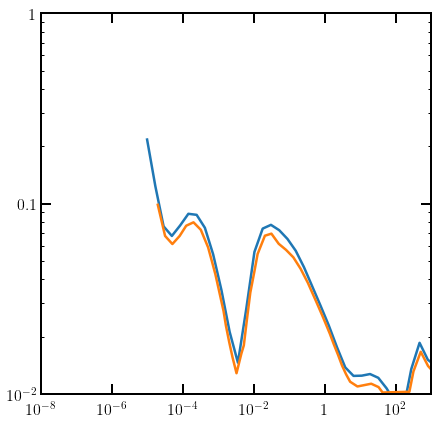

In [60]:
plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(mDM_list/1e9, fHion_list)
plt.plot(2*f_CLW[:,0]/1e9, f_CLW[:,1])
plt.axis([1e-8,1e3,1.e-2,1])
plt.show()

1.1423449928331575


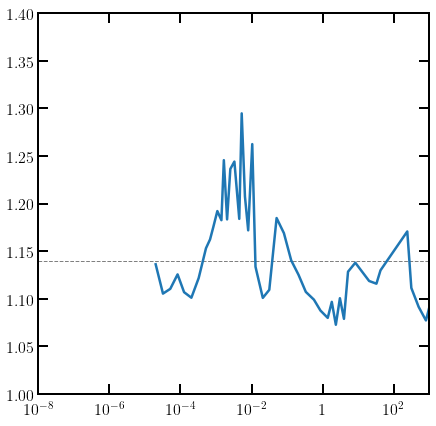

In [72]:
interp_DH = interp1d(mDM_list, fHion_list)
interp_CLW = interp1d(2*f_CLW[:,0], f_CLW[:,1])
print(np.mean(interp_DH(2*f_CLW[:,0]) / interp_CLW(2*f_CLW[:,0])))

plt.figure(figsize=(7,7))
plt.xscale('log')
plt.plot(2*f_CLW[:,0]/1e9, interp_DH(2*f_CLW[:,0]) / interp_CLW(2*f_CLW[:,0]))
plt.hlines(1.14, 1e-8, 1e3, color='grey', linestyle='--', linewidth=1)
plt.axis([1e-8,1e3,1,1.4])
plt.show()

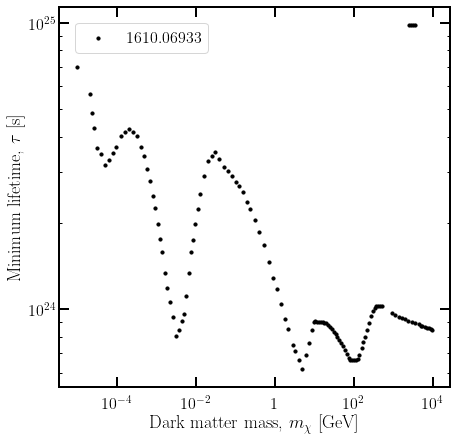

In [33]:
mDM_list = np.logspace(4,12.98,num=100)

plt.figure(figsize=(7,7))
plt.loglog()
plt.scatter(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:], 
            label='1610.06933', color='k', s=10)
plt.xlabel(r'Dark matter mass, $m_\chi$ [GeV]')
plt.ylabel(r'Minimum lifetime, $\tau$ [s]')
plt.legend()
plt.show()